<a href="https://colab.research.google.com/github/benpkxd/Data-Analysis-Skills/blob/main/Dataprep%2BDataAnalyze/Python_AB_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
zhangluyuan_ab_testing_path = kagglehub.dataset_download('zhangluyuan/ab-testing')

print('Data source import complete.')


Choosing the variables
For our test we'll need two groups:

A control group - They'll be shown the old design
A treatment (or experimental) group - They'll be shown the new design
This will be our Independent Variable. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

0 - The user did not buy the product during this user session
1 - The user bought the product during this user session
This way, we can easily calculate the mean for each group to get the conversion rate of each design.

Choosing a sample size
It is important to note that since we won't test the whole user base (our population), the conversion rates that we'll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

So how many people should we have in each group?

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:

Power of the test (
) - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on statistical power, if you are curious)
Alpha value (
) - The critical value we set earlier to 0.05
Effect size - How big of a difference we expect there to be between the conversion rates
Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

In [ ]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
sns.set_style('whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

# **1.Data Entry**

In [ ]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number

print(required_n)

4720


We'd need at least 4720 observations for each group.

In [ ]:
df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


# **2. Data Preparation**

In [ ]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [ ]:
# make sure there are no users that have been sampled multiple times.
count = df['user_id'].value_counts(ascending=False)
multi_users = count[count > 1].count()
print(f'There are {multi_users} multiply times users')

There are 3894 multiply times users


In [ ]:
# remove duplicate
remove_users = count[count>1].index
df = df[~df['user_id'].isin(remove_users)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       286690 non-null  int64 
 1   timestamp     286690 non-null  object
 2   group         286690 non-null  object
 3   landing_page  286690 non-null  object
 4   converted     286690 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.1+ MB


# **3.Random Sampling**

In [ ]:
#we can proceed and sample n=4720 entries for each of the groups
ctrl = df[df['group']=='control'].sample(n=required_n,random_state=20)
trt = df[df['group']=='treatment'].sample(n=required_n,random_state=20)

ab_test = pd.concat([ctrl,trt],axis=0)
ab_test.reset_index(drop=True,inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,714963,2017-01-07 23:04:42.723921,control,old_page,0
1,708211,2017-01-16 12:33:36.052481,control,old_page,0
2,918584,2017-01-05 15:27:46.426383,control,old_page,0
3,687179,2017-01-24 08:28:13.814195,control,old_page,0
4,854287,2017-01-15 13:19:23.463341,control,old_page,0
...,...,...,...,...,...
9435,670620,2017-01-07 09:42:41.902873,treatment,new_page,0
9436,888446,2017-01-22 18:57:39.133948,treatment,new_page,0
9437,818646,2017-01-18 15:36:21.132817,treatment,new_page,0
9438,904550,2017-01-18 10:40:37.225077,treatment,new_page,1


In [ ]:
ab_test['group'].value_counts()

group
control      4720
treatment    4720
Name: count, dtype: int64

# **4.Test the hypothesis**

In [ ]:
conversion = ab_test.groupby('group')['converted']
std_p = lambda x:np.std(x, ddof=0) # SD. of the propotion
se_p = lambda x:stats.sem(x, ddof=0) # SE. of the propotion (std/sqrt(n))

conversion = conversion.agg([np.mean, std_p,se_p])
conversion.columns = ['conversion_rate','std_deviation','std_error']

conversion

<ipython-input-14-c7a0895551c2>:5: FutureWarning: The provided callable <function mean at 0x7e2c96de8790> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion = conversion.agg([np.mean, std_p,se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.114831,0.318817,0.004641
treatment,0.116949,0.321360,0.004678


In [ ]:
conversion.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.115,0.319,0.005
treatment,0.117,0.321,0.005


Result show 2 groups performed similarly (conversion rate 11.5%,11.7%)

Text(0, 0.5, 'Converted(proportion)')

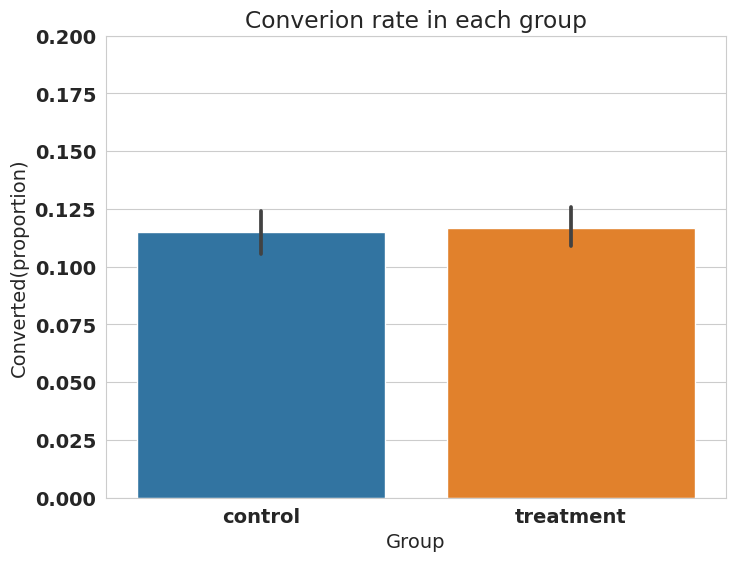

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x=ab_test['group'],y=ab_test['converted'])

plt.ylim(0,0.2)
plt.title('Converion rate in each group')
plt.xlabel('Group')
plt.ylabel('Converted(proportion)')

# **5. Generate Statistics**

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
ctrl_result = ab_test[ab_test['group']=='control']['converted']
trt_result = ab_test[ab_test['group']=='treatment']['converted']

In [ ]:
n_con = ctrl_result.count()
n_treat = trt_result.count()
n_treat

4720

In [ ]:
success = [ctrl_result.sum(),trt_result.sum()]
success

[542, 552]

In [ ]:
nobs = [n_con,n_treat]
nobs

[4720, 4720]

In [ ]:
z_stat, pval = proportions_ztest(success,nobs=nobs)
(lower_con,lower_treat),(upper_con,upper_treat)=proportion_confint(success,nobs=nobs,alpha=0.05)

print(f'z stat : {z_stat:.2f}')
print(f'p-value:{pval:.4f}')
print(f'ci 95% for control:[{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% for treatment:[{lower_treat:.3f},{upper_treat:.3f}]')

z stat : -0.32
p-value:0.7478
ci 95% for control:[0.106,0.124]
ci 95% for treatment:[0.108,0.126]


we cannot reject the null hypothesis , which means that these two groups did not perform **significantly** different